<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Multilabel Classification

In this notebook, we will look at the best practices for doing multilabel classification. 

In the previous notebook, we performed multi-class/single-label classification, which assumes that each image is assigned to only one label: an animal can be either an dog or a cat but not both at the same time. Multi-label classification on the other hand, will assume that each image can contain or represent multiple different labels: a landscape can be labeled both gloomy (weather) and of a beach (subject).

In this notebook, we'll train a multilabel classifier and examine how best to structure data for multilabel classification problems as well as learn about new ways to evaluate our results. 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai and other libraries needed. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [2]:
import sys
sys.path.append("../../")

import warnings
warnings.filterwarnings('ignore')

import inspect
import numpy as np
import pandas as pd
from pathlib import Path

# fastai and torch
import fastai
from fastai.vision import *

# local modules
from utils_cv.classification.model import TrainMetricsRecorder, hamming_loss, zero_one_loss
from utils_cv.classification.plot import plot_pr_roc_curves, plot_loss_thresholds
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB
Available / Total memory = 13926 / 16130 (MiB)


Like before, we set some parameters. This time, we can use one of the multilabel datasets that comes with this repo.

In [3]:
DATA_PATH     = unzip_url(Urls.multilabel_fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## 1. Preparing Image Data for Multilabel Classification

In this notebook, we'll look at different kinds of beverages. In the repo, under `data`, we've downloaded a directory titled: __multilabelFridgeObjects__.

Lets set that directory to our `path` variable, which we'll use throughout the notebook. We'll also inspect what's inside to get an understanding of how to structure images for multilabel classification.

In [4]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/models'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/labels.csv'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images')]

Lets inspect the `/images` folder:

In [5]:
(path/'images').ls()[:5]

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/16.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/98.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/66.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/76.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/33.jpg')]

Lets also take a look at the `labels.csv` file using pandas. 

In [6]:
df = pd.read_csv(path/'labels.csv'); df.sample(5)

,filename,labels
43,44.jpg,water_bottle carton milk_bottle
122,123.jpg,carton can
0,1.jpg,carton
1,2.jpg,milk_bottle
106,107.jpg,milk_bottle can


As shown above, the contents of the csv file is a mapping of the filename to the labels. Since this is a multilabel classificaiton problem, each image can be associated to multiple labels.

This is one of the most common data formast for multilabel image classification; one csv file that contains the mapping of labels to a folder of images:

```
/images
+-- labels.csv
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
|   +-- image131.jpg
|   +-- image132.jpg
```

## 2. Load labels and images

__Loading data__

Now that we know the structure of our data, lets use fast.ai's data block apis to create our databunches so that we can easily load mini-batches of data from our filesystem into our trainer.

In [7]:
np.random.seed(42)
data = (ImageList.from_csv(path, 'labels.csv', folder='images')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' ')
       .transform(size=299)
       .databunch(bs=32)
       .normalize(imagenet_stats))

Lets break down the code:

The first thing we need to do is to create an `ImageList`, and we'll do so by creating it from a csv file (`from_csv`). Then we want to do a random split (`random_split_by_pct`) so that we have our validation set. For this method, we've also set a random seed (`np.random.seed(42)`) so that our validation set is consistent. Finally we want to get our labels from the df (`label_from_df`) that comes from the csv file. Since our labels are space-seperated in the csv file, we want to specify that our labels will be delimited by a space (`label_delim=' '`). 

In the second part, we use the `ImageList` we created and apply a transformation on it (`transform`) so that all images are resized to 299X299. Then we turn it into a databunch, which is basically the kind of object fastai's trainer uses to load mini-batches of data. Finally we'll normalize the databunch (`normalize(imagenet_states)` to the imagenet parameters.

__Inpsect data__

To make sure our data is correctly loaded, lets print out the number of classes, and each of the class labels.

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


We can also call `batch_stats` on our databunch object to get a view on how the data is split between training and validation.

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton,milk_bottle,can,water_bottle,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Valid: LabelList (25 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton;can;milk_bottle,water_bottle;carton;milk_bottle,water_bottle;can,milk_bottle;water_bottle;can,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Test: None>

Lets get a sample of what the data looks like.

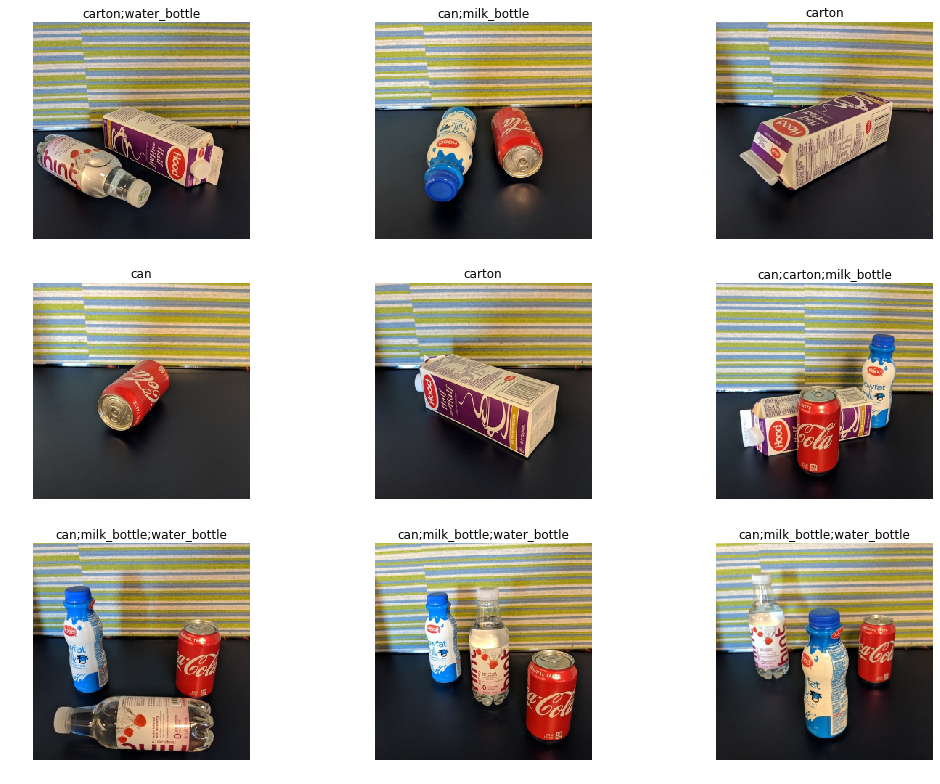

In [10]:
data.show_batch(rows=3, figsize=(15, 11))

# 3. Training our multilabel classifier

One of the main differences between training a multilabel classifier an a single-label classifier is how we may want to evaluate our model. In a single-label (multi-class) classification model, we often use a model's accuracy to see how well a model performs. But _accuracy_ as an evaluation metric isn't specific enough when it comes to multilabel classification problems.

__The Problem With Accuracy__

For multilabel classification problems, a misclassification is not binary: right or wrong. Instead a prediction containing a subset of the correct labels we're looking for is better than one that contains none of them. For example, in an image that is labelled both 'rainy' and 'forest', it is usually better to predict one correct label than neither of the correct labels. 

One of the other problems when it comes to calculating accuracy is that the softmax activation function does not work well for multilabel classification problems. In single-label classification, we usually use a softmax function on the output of our neural network because we want to express a dependency across the labels; if the picture is likely of a _dog_, then it is unlikely of a _cat_. By applying a softmax on the output, we force the sum of the values to 1, enforcing this dependency.

For multilabel classification, label likelihoods are independent from each other; the likelihood of an image being _rainy_ is independent from the likelihood of it being a _forest_. Instead of the softmax function, we can use the sigmoid activation function to normalize our result while preserving the independent relationship of each label.


__Hamming Loss__

One of the most common ways to evaluate a multilabel classification problem is by using the hamming loss, which we can think of as the fraction of wrong labels to the total number of labels. 

For example, lets say our validation set contains 4 images and the results looks as such:
```
+-------+------------------+------------------+------------------+
| Image |  y_true:         |  y_pred:         |  hamming_loss:   |
|-------+------------------+------------------+------------------+
| im_01 |  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |  [[0, 0, 0, 1],  |
| im_02 |   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |   [0, 1, 0, 0],  |
| im_03 |   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |   [0, 0, 0, 0],  |
| im_04 |   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |   [0, 0, 1, 0]]  |
+-------+------------------+------------------+------------------+
|                                             | = 3/25 incorrect |
+-------+------------------+------------------+------------------+
```
In this case, the predictions has 3 out of a total of 16 predictions that are not true, so the hamming loss is __0.1875__.

__Zero-one Loss__

Zero-one loss is a much harsher evaluation metric than hamming loss. The zero-one loss will classify an entire set of labels for a given sample incorrect if it does not entirely match the true set of labels. Hamming loss is more forgiving since it penalizes only the individual labels themselves.

Once again, lets say our validation set contains 4 images and the results looks as such:
```
+-------+------------------+------------------+------------------+
| Image |  y_true:         |  y_pred:         |  zero_one_loss:  |
|-------+------------------+------------------+------------------+
| im_01 |  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |  [[1],           |
| im_02 |   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |   [1],           |
| im_03 |   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |   [0],           |
| im_04 |   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |   [1]]           |
+-------+------------------+------------------+------------------+
|                                             | = 3/4 incorrect  |
+-------+------------------+------------------+------------------+
```
In this case, the predictions have only classified 3 individual labels incorrectly. But since we're using zero-one loss, and each of those misclassifications are in a different set, we end up with a zero-one loss of __0.75__. If we compare this to hamming loss, we can see that it is a much less forgiving metric.

While hamming loss and zero-one loss are a common evaluation metric for multilabel classification, note that it may not be ideal for all multilabel classification problems. For each problem, you need to access what you're evaluating your model against to see if it is a good fit. 

---


If we want to take advantage of using Hamming Loss, we'll need to define our own evaluation metric. To do this, we'll need to create a custom function that will takes a `y_pred` and a `y_true`, and returns a single metric. 

> Since we've defined our hamming loss and zero-one loss functions in the `utils_cv.classification.models` module, lets just print out them out to see what they looks like.


In [11]:
print(inspect.getsource(hamming_loss))

def hamming_loss(
    y_pred: Tensor,
    y_true: Tensor,
    threshold: float = 0.2,
    sigmoid: bool = False,
) -> Tensor:
    """ Callback for using hamming loss as a evaluation metric.

    Hamming loss is the fraction of wrong labels to the total number of labels.

    Args:
        y_pred: prediction output
        y_true: true class labels
        threshold: the threshold to consider a positive classification
        sigmoid: whether to apply the sigmoid activation

    Returns:
        The hamming loss function as a tensor of dtype float
    """
    if sigmoid:
        y_pred = y_pred.sigmoid()
    if threshold:
        y_pred = y_pred > threshold
    return (y_pred.float() != y_true).sum() / torch.ones(y_pred.shape).sum()



In [12]:
print(inspect.getsource(zero_one_loss))

def zero_one_loss(
    y_pred: Tensor,
    y_true: Tensor,
    threshold: float = 0.2,
    sigmoid: bool = False,
) -> Tensor:
    """ Callback for using zero-one loss as a evaluation metric.

    The zero-one loss will classify an entire set of labels for a given sample
    incorrect if it does not entirely match the true set of labels.

    Args:
        y_pred: prediction output
        y_true: true class labels
        threshold: the threshold to consider a positive classification
        sigmoid: whether to apply the sigmoid activation

    Returns:
        The zero-one loss function as a tensor with dtype float
    """
    if sigmoid:
        y_pred = y_pred.sigmoid()
    if threshold:
        y_pred = y_pred > threshold

    zero_one_preds = (y_pred.float() != y_true).sum(dim=1)
    zero_one_preds[zero_one_preds >= 1] = 1
    num_labels = y_pred.shape[-1]
    return zero_one_preds.sum().float() / len(y_pred.reshape(-1, num_labels))



We'll use the `create_cnn` function to create our CNN, passing in our custom `hamming_loss` function.

In [13]:
learn = cnn_learner(
    data, 
    ARCHITECTURE, 
    metrics=[hamming_loss, zero_one_loss],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Unfreeze our CNN since we're training all the layers.

In [14]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

epoch,train_loss,valid_loss,train_hamming_loss,valid_hamming_loss,train_zero_one_loss,valid_zero_one_loss,time
0,0.812990,0.650907,0.507812,0.410000,0.125000,0.840000,00:08
1,0.606365,0.567497,0.208333,0.330000,0.125000,0.800000,00:02
2,0.492681,0.508165,0.111979,0.270000,0.125000,0.720000,00:02
3,0.429096,0.467863,0.119792,0.220000,0.125000,0.720000,00:02
4,0.376891,0.425242,0.078125,0.220000,0.125000,0.720000,00:02
5,0.332933,0.391576,0.033854,0.170000,0.093750,0.600000,00:02
6,0.298333,0.364354,0.031250,0.130000,0.062500,0.480000,00:02
7,0.269683,0.344369,0.023438,0.120000,0.052083,0.440000,00:02
8,0.245974,0.322826,0.020833,0.120000,0.041667,0.400000,00:02
9,0.225110,0.301621,0.013021,0.090000,0.041667,0.320000,00:02


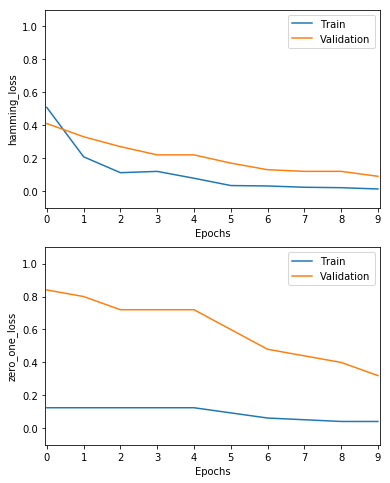

In [15]:
learn.fit(EPOCHS, LEARNING_RATE)

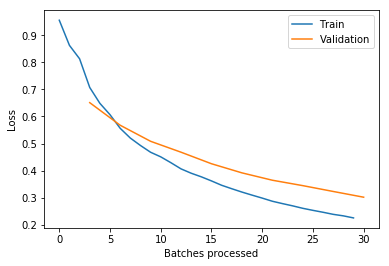

In [16]:
learn.recorder.plot_losses()

## 4. Evaluate the model

The learner comes with a handy function `show_results` that will show one mini-batch of the validation set. We can use that to get an intuitive sense of what is being predicted correctly and what is not.

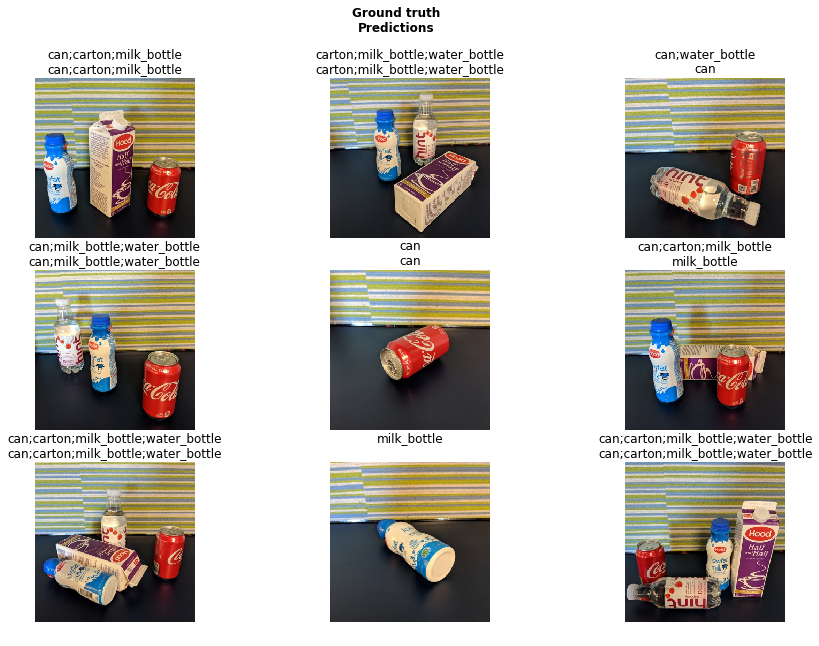

In [17]:
learn.show_results(rows=3, figsize=(15, 10))

To concretely evaluate our model, lets take a look at the hamming loss on the validation set. We can think of this value as the percentage of the total incorrect classifications out of the total possible classifications.

In [18]:
_, hl, zol = learn.validate(learn.data.valid_dl, metrics=[hamming_loss, zero_one_loss])
print(f'Hamming Loss on validation set: {float(hl):3.2f}')
print(f'Zero-one Loss on validation set: {float(zol):3.2f}')

Hamming Loss on validation set: 0.09
Zero-one Loss on validation set: 0.32


We've calculated the hamming loss on our validation set with the default probability threshold of 0.2. However, this default value may not be the most optimal value. We can use the `plot_loss_thresholds` function to plot the evaluation metric at different levels of thresholds. If, for example, we were interested in the zero-one loss, but we noticed that the default threshold is far from the minimum, we may consider using a different threshold when we perform inferencing. Lets plot the zero-one loss at various thresholds to what the most optimal threshold is.

Note that the threshold represents a trade-off between specificity and sensitivity. The higher the threshold, the higher the _specificity_. The lower the threshold, the higher the _sensivity_.

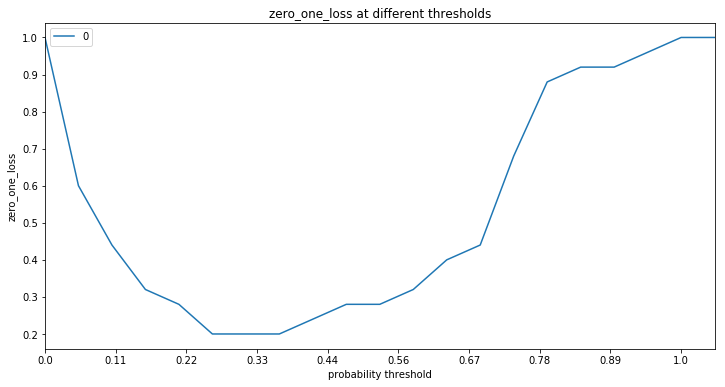

In [19]:
interp = learn.interpret()
plot_loss_thresholds(zero_one_loss, interp.probs, interp.y_true)

We can clearly see that the default threshold value of 0.2 is not the mininum. Lets move the threshold to achieve a better loss.

In [20]:
zero_one_loss(interp.probs, interp.y_true, threshold=0.3)

tensor(0.2000)

Other than looking at zero-one loss and hamming loss, we can also plot the recision-recall and ROC curves for each class. 

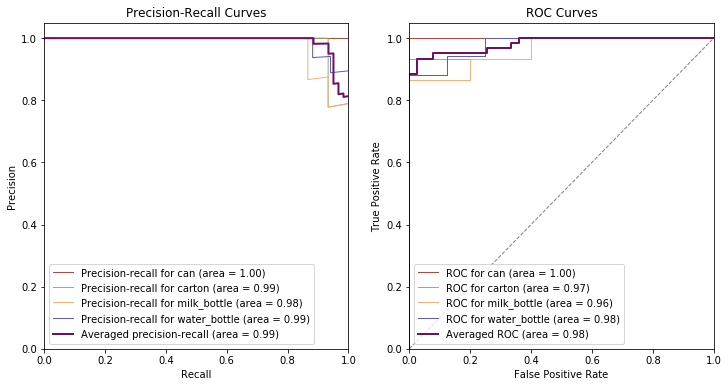

In [21]:
# True labels of the validation set. We convert to numpy array for plotting.
plot_pr_roc_curves(
    to_np(interp.y_true), 
    to_np(interp.probs), 
    data.classes
)